In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from IPython.display import Image, display

FVM 基礎工具

In [2]:
def gradient_fd(f, dx):
    grad = np.zeros_like(f)
    grad[1:-1] = (f[2:] - f[:-2]) / (2.0 * dx)
    grad[0] = (-3.0 * f[0] + 4.0 * f[1] - f[2]) / (2.0 * dx)
    grad[-1] = (3.0 * f[-1] - 4.0 * f[-2] + f[-3]) / (2.0 * dx)
    return grad


def build_u_center_and_u_face(rho, dx, D, rho_L, rho_R):
    nx = rho.size
    rho_ext = np.empty(nx + 2)
    rho_ext[1:-1] = rho
    rho_ext[0] = rho_L
    rho_ext[-1] = rho_R

    log_rho_ext = np.log(np.clip(rho_ext, 1e-12, None))

    u_center = -D * (log_rho_ext[2:] - log_rho_ext[:-2]) / (2.0 * dx)

    u_face = np.zeros(nx + 1)
    u_face[1:-1] = 0.5 * (u_center[:-1] + u_center[1:])
    u_face[0] = -D * 2.0 * (log_rho_ext[1] - log_rho_ext[0]) / dx
    u_face[-1] = -D * 2.0 * (log_rho_ext[-1] - log_rho_ext[-2]) / dx

    return u_center, u_face


def upwind_flux(q_L, q_R, u_face):
    return u_face * (q_L if u_face > 0.0 else q_R)


def solve_fvm_I(I_n, u_face, dx, dt):
    nx = len(I_n)
    I_next = I_n.copy()
    flux = np.zeros(nx + 1)
    for j in range(1, nx):
        flux[j] = upwind_flux(I_n[j - 1], I_n[j], u_face[j])
    I_next[1:-1] = I_n[1:-1] - (dt / dx) * (flux[2:-1] - flux[1:-2])
    return I_next

插值

In [3]:
def interpolate(q, x_d, dx, X_MIN, method='cubic'):

    nx = len(q)
    x_min_c = X_MIN + 0.5 * dx

    # 1. 計算歸一化坐標 s
    # s = i + w, 其中 i 是左側最近的 cell index
    s = (x_d - x_min_c) / dx

    # 限制在網格範圍內，避免外插太遠
    s = np.clip(s, 0, nx - 1.000001)

    i = np.floor(s).astype(int)
    w = s - i  # 小數部分 0 <= w < 1

    # 2. 準備 Padding 數據 (Ghost Cells)
    # 為了支援 cubic/hermite 至少需要左右各多 2 格
    # 使用 'edge' 模式重複邊界值 (Dirichlet 近似)
    pad_width = 2
    q_pad = np.pad(q, (pad_width, pad_width), mode='edge')

    # 因為 pad 了 2 格，原來的 index i 在 q_pad 中變成 i + 2
    # 定義基準索引 J
    J = i + pad_width

    # 預先取出 Stencil 點的值
    y_m1 = q_pad[J - 1]  # y_{i-1}
    y_0 = q_pad[J]      # y_{i}
    y_p1 = q_pad[J + 1]  # y_{i+1}
    y_p2 = q_pad[J + 2]  # y_{i+2}

    if method == 'linear':
        # Linear: (1-w)*y0 + w*y1
        return (1.0 - w) * y_0 + w * y_p1

    elif method == 'quadratic':
        # Quadratic (Lagrange 3-point)
        # 使用以 y_0 為中心的 3 點 (i-1, i, i+1)
        val = (0.5 * w * (w - 1.0)) * y_m1 + \
              (1.0 - w**2) * y_0 + \
              (0.5 * w * (w + 1.0)) * y_p1
        return val

    elif method == 'cubic':
        # Cubic Lagrange (4-point) using i-1, i, i+1, i+2
        c_m1 = -w * (w - 1) * (w - 2) / 6.0
        c_0 = (w + 1) * (w - 1) * (w - 2) / 2.0
        c_p1 = -(w + 1) * w * (w - 2) / 2.0
        c_p2 = (w + 1) * w * (w - 1) / 6.0

        return c_m1 * y_m1 + c_0 * y_0 + c_p1 * y_p1 + c_p2 * y_p2

    elif method == 'hermite':
        # Cubic Hermite Spline
        p0 = y_0
        p1 = y_p1

        m0 = 0.5 * (y_p1 - y_m1)
        m1 = 0.5 * (y_p2 - y_0)

        t = w
        t2 = t * t
        t3 = t2 * t

        h00 = 2*t3 - 3*t2 + 1
        h10 = t3 - 2*t2 + t
        h01 = -2*t3 + 3*t2
        h11 = t3 - t2

        return h00*p0 + h10*m0 + h01*p1 + h11*m1

    else:
        raise ValueError(f"Unknown interpolation method: {method}")

semi-Lagrangian

In [4]:
def backtrace_RK2(u_center, x_i, dt, dx, X_MIN, X_MAX):
    # Predictor
    x_pred = x_i - dt * u_center
    # Velocity usually smooth enough so linear is okay for trajectory
    u_pred = interpolate(u_center, x_pred, dx, X_MIN, method='linear')

    # Corrector
    u_mid = 0.5 * (u_center + u_pred)
    xd = x_i - dt * u_mid

    x_min_c = X_MIN + 0.5 * dx
    x_max_c = X_MAX - 0.5 * dx
    return np.clip(xd, x_min_c, x_max_c)


def sl_update_K(K_n, u_center, dx, dt, X_MIN, X_MAX, method='cubic'):
    nx = len(K_n)
    x_i = X_MIN + (np.arange(nx) + 0.5) * dx

    # Backtrace
    xd = backtrace_RK2(u_center, x_i, dt, dx, X_MIN, X_MAX)

    # Interpolate old values at departure points
    K_d = interpolate(K_n, xd, dx, X_MIN, method=method)

    return K_d


def sl_update_R(R_n, u_center, r_over_I, dx, dt, X_MIN, X_MAX, method='cubic'):
    nx = len(R_n)
    x_i = X_MIN + (np.arange(nx) + 0.5) * dx

    xd = backtrace_RK2(u_center, x_i, dt, dx, X_MIN, X_MAX)

    # Interpolate R and Source term
    R_d = interpolate(R_n,       xd, dx, X_MIN, method=method)
    src_d = interpolate(r_over_I, xd, dx, X_MIN, method=method)

    # Euler integral along characteristic
    return R_d + dt * src_d

In [5]:
def fkpp_exact(x, t, D, x0=0.0):
    c = 5.0 * np.sqrt(D / 6.0)
    L = np.sqrt(6.0 * D)
    z = (x - c * t - x0) / L
    return 1.0 / (1.0 + np.exp(z))**2


def run_simulation(D=1.0, X_MIN=-10.0, X_MAX=20.0,
                   T_MAX=10.0, NX=201, NT=1601, x0_wave=0.0,
                   interp_method='cubic'):

    DX = (X_MAX - X_MIN) / NX
    DT = T_MAX / (NT - 1)
    x = X_MIN + (np.arange(NX) + 0.5) * DX

    rho0 = fkpp_exact(x, 0.0, D, x0_wave)

    I_current = np.ones_like(rho0)
    K_current = rho0.copy()
    R_current = np.zeros_like(rho0)
    rho_current = rho0.copy()

    rho_history = np.zeros((NT, NX))
    u_history = np.zeros((NT, NX))
    rho_history[0] = rho0.copy()

    # Initial velocity
    rho_L = fkpp_exact(X_MIN, 0.0, D, x0_wave)
    rho_R = fkpp_exact(X_MAX, 0.0, D, x0_wave)
    u_c0, _ = build_u_center_and_u_face(rho0, DX, D, rho_L, rho_R)
    u_history[0] = u_c0.copy()

    time_steps = np.linspace(0.0, T_MAX, NT)

    for n in range(1, NT):
        t_n = time_steps[n - 1]
        t_np1 = time_steps[n]

        rho_L = fkpp_exact(X_MIN, t_n, D, x0_wave)
        rho_R = fkpp_exact(X_MAX, t_n, D, x0_wave)

        # 1. Update Velocity
        u_center, u_face = build_u_center_and_u_face(
            rho_current, DX, D, rho_L, rho_R
        )
        max_vel = DX / DT
        u_center = np.clip(u_center, -max_vel, max_vel)
        u_face = np.clip(u_face, -max_vel, max_vel)

        # 2. Source Terms
        r = rho_current - rho_current**2
        r_over_I = r / np.clip(I_current, 1e-12, None)

        # 3. Solvers
        # I (FVM)
        I_next = solve_fvm_I(I_current, u_face, DX, DT)

        # K, R (Semi-Lagrangian with High Order Interp)
        K_next = sl_update_K(K_current, u_center, DX, DT,
                             X_MIN, X_MAX, method=interp_method)
        R_next = sl_update_R(R_current, u_center, r_over_I,
                             DX, DT, X_MIN, X_MAX, method=interp_method)

        # 4. Reconstruction
        rho_next = (K_next + R_next) * I_next

        # 5. Boundary Enforcement
        rho_L_np1 = fkpp_exact(X_MIN, t_np1, D, x0_wave)
        rho_R_np1 = fkpp_exact(X_MAX, t_np1, D, x0_wave)

        rho_next[0] = rho_L_np1
        rho_next[-1] = rho_R_np1

        I_next[0], I_next[-1] = 1.0, 1.0
        R_next[0], R_next[-1] = 0.0, 0.0
        K_next[0], K_next[-1] = rho_L_np1, rho_R_np1

        rho_next = np.clip(rho_next, 1e-12, 1.0)

        rho_history[n] = rho_next.copy()
        u_history[n] = u_center.copy()

        I_current, K_current, R_current = I_next, K_next, R_next
        rho_current = rho_next

    return x, rho_history, u_history, time_steps

視覺化

In [ ]:
def plot_results(x, time_steps, rho_num, rho_ex, u_hist,
                 X_MIN, X_MAX, interp_method, output_dir="results_SL"):
    
    output_dir = f"{output_dir}_{interp_method}"
    os.makedirs(output_dir, exist_ok=True)

    squared_error = (rho_num - rho_ex)**2
    mse_hist = np.mean(squared_error, axis=1)
    print(f"[{interp_method.upper()}] Max MSE: {np.max(mse_hist):.6e}")

    frame_indices = list(range(0, len(time_steps), 20))
    if frame_indices[-1] != len(time_steps) - 1:
        frame_indices.append(len(time_steps) - 1)
        
    writer = PillowWriter(fps=20)

    # 1. Simulation
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    l1, = ax1.plot([], [], 'r--', label=f'SL ({interp_method}) + FVM')
    l2, = ax1.plot([], [], 'g:', lw=3, label='Exact')
    txt1 = ax1.text(0.05, 0.9, "", transform=ax1.transAxes)
    ax1.set_xlim(X_MIN, X_MAX)
    ax1.set_ylim(-0.1, 1.1)
    ax1.set_xlabel("x")
    ax1.set_ylabel(r"$\rho$")
    ax1.legend()
    ax1.grid(True)

    def update1(k):
        n = frame_indices[k]
        l1.set_data(x, rho_num[n])
        l2.set_data(x, rho_ex[n])
        txt1.set_text(f"t={time_steps[n]:.2f}, MSE={mse_hist[n]:.2e}")
        return l1, l2, txt1

    anim1 = FuncAnimation(fig1, update1, frames=len(frame_indices), interval=50, blit=True)
    sim_path = os.path.join(output_dir, "simulation.gif")
    anim1.save(sim_path, writer=writer)
    plt.close(fig1)

    # 2. MSE
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    l3, = ax2.plot([], [], 'b-')
    txt2 = ax2.text(0.05, 0.9, "", transform=ax2.transAxes)
    ax2.set_xlim(X_MIN, X_MAX)
    max_sq = np.max(squared_error)
    ax2.set_ylim(0, max_sq*1.1 if max_sq > 0 else 1)
    ax2.set_xlabel("x")
    ax2.set_ylabel("Squared Error")
    ax2.grid(True)

    def update2(k):
        n = frame_indices[k]
        l3.set_data(x, squared_error[n])
        txt2.set_text(f"t={time_steps[n]:.2f}")
        return l3, txt2

    anim2 = FuncAnimation(fig2, update2, frames=len(frame_indices), interval=50, blit=True)
    mse_path = os.path.join(output_dir, "mse.gif")
    anim2.save(mse_path, writer=writer)
    plt.close(fig2)

    # 3. Velocity
    fig3, ax3 = plt.subplots(figsize=(8, 5))
    l4, = ax3.plot([], [], 'm-')
    txt3 = ax3.text(0.05, 0.9, "", transform=ax3.transAxes)
    ax3.set_xlim(X_MIN, X_MAX)
    u_min, u_max = np.min(u_hist), np.max(u_hist)
    ax3.set_ylim(u_min - 0.5, u_max + 0.5)
    ax3.set_xlabel("x")
    ax3.set_ylabel("u")
    ax3.grid(True)

    def update3(k):
        n = frame_indices[k]
        l4.set_data(x, u_hist[n])
        txt3.set_text(f"t={time_steps[n]:.2f}")
        return l4, txt3

    anim3 = FuncAnimation(fig3, update3, frames=len(frame_indices), interval=50, blit=True)
    vel_path = os.path.join(output_dir, "velocity.gif")
    anim3.save(vel_path, writer=writer)
    plt.close(fig3)

    return sim_path, mse_path, vel_path

Running SL Simulation with cubic interpolation...
[CUBIC] Max MSE: 2.706899e-06

--- Simulation Results ---
1. Density Evolution:


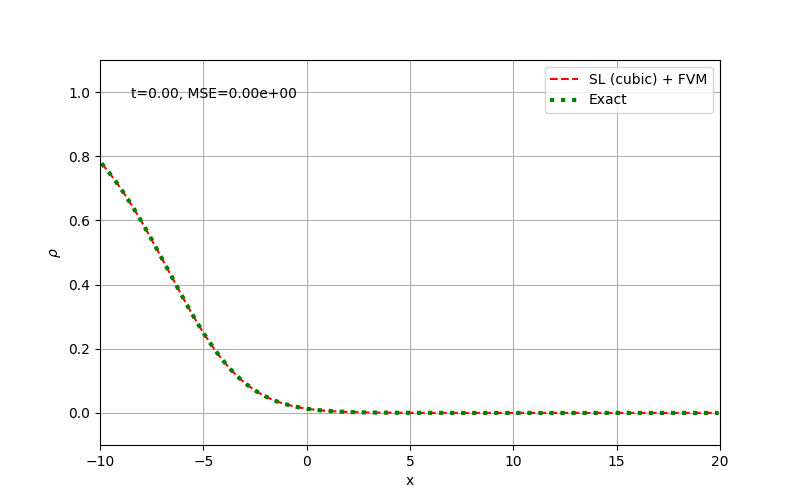


2. Squared Error:


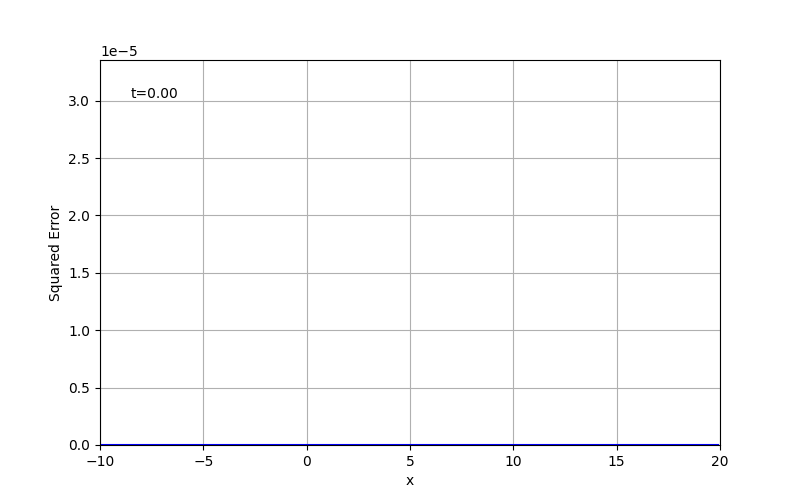


3. Velocity Field:


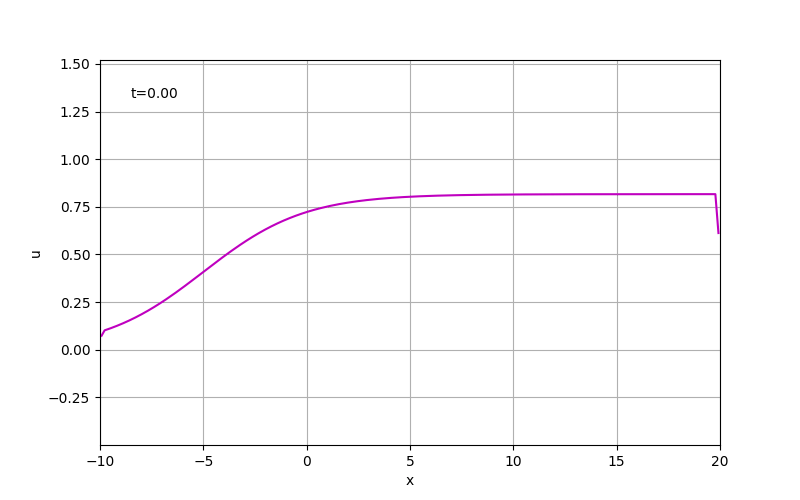

In [7]:
# 可選模式: 'linear', 'quadratic', 'cubic', 'hermite'
INTERP_METHOD = 'cubic' 

D = 1.0
X_MIN, X_MAX = -10.0, 20.0
T_MAX = 10.0
NX, NT = 201, 1601
x0_wave = -5.0

print(f"Running SL Simulation with {INTERP_METHOD} interpolation...")

# 執行計算
x, rho_num, u_hist, time_steps = run_simulation(
    D=D, X_MIN=X_MIN, X_MAX=X_MAX,
    T_MAX=T_MAX, NX=NX, NT=NT, x0_wave=x0_wave,
    interp_method=INTERP_METHOD
)

# 計算精確解
rho_ex = np.array([fkpp_exact(x, t, D, x0_wave) for t in time_steps])

# 繪圖並取得路徑
sim_path, mse_path, vel_path = plot_results(
    x, time_steps, rho_num, rho_ex, u_hist,
    X_MIN, X_MAX, interp_method=INTERP_METHOD
)

print("\n--- Simulation Results ---")
print("1. Density Evolution:")
display(Image(filename=sim_path))

print("\n2. Squared Error:")
display(Image(filename=mse_path))

print("\n3. Velocity Field:")
display(Image(filename=vel_path))